In [23]:
# visualization code from logger
import importlib
from datetime import datetime


class TensorboardWriter():
    def __init__(self, log_dir, logger, enabled):
        self.writer = None
        self.selected_module = ""

        if enabled:
            log_dir = str(log_dir)

            # Retrieve vizualization writer.
            succeeded = False
            for module in ["torch.utils.tensorboard", "tensorboardX"]:
                try:
                    self.writer = importlib.import_module(module).SummaryWriter(log_dir)
                    succeeded = True
                    break
                except ImportError:
                    succeeded = False
                self.selected_module = module

            if not succeeded:
                message = "Warning: visualization (Tensorboard) is configured to use, but currently not installed on " \
                    "this machine. Please install TensorboardX with 'pip install tensorboardx', upgrade PyTorch to " \
                    "version >= 1.1 to use 'torch.utils.tensorboard' or turn off the option in the 'config.json' file."
                logger.warning(message)

        self.step = 0
        self.mode = ''

        self.tb_writer_ftns = {
            'add_scalar', 'add_scalars', 'add_image', 'add_images', 'add_audio',
            'add_text', 'add_histogram', 'add_pr_curve', 'add_embedding','add_graph'
        }
        self.tag_mode_exceptions = {'add_graph','add_histogram', 'add_embedding'}
        self.timer = datetime.now()

    def set_step(self, step, mode='train'):
        self.mode = mode
        self.step = step
        if step == 0:
            self.timer = datetime.now()
        else:
            duration = datetime.now() - self.timer
            self.add_scalar('steps_per_sec', 1 / duration.total_seconds())
            self.timer = datetime.now()

    # def add_graph(self, model, input_to_model=None, verbose=False, use_strict_trace=True):
        # if self.writer is not None:
            # self.writer.add_graph(model, input_to_model, verbose, use_strict_trace)

    def __getattr__(self, name):
        """
        If visualization is configured to use:
            return add_data() methods of tensorboard with additional information (step, tag) added.
        Otherwise:
            return a blank function handle that does nothing
        """
        if name in self.tb_writer_ftns:
            # Loads the actual function from tensorboard, with the current writer's method as default.
            add_data = getattr(self.writer, name, None)

            def wrapper(tag, data, *args, **kwargs):
                if add_data is not None:
                    # add mode(train/valid) tag
                    if name not in self.tag_mode_exceptions:
                        tag = '{}/{}'.format(tag, self.mode)
                    add_data(tag, data, self.step, *args, **kwargs)
            return wrapper
        else:
            # default action for returning methods defined in this class, set_step() for instance.
            try:
                attr = object.__getattr__(name)
            except AttributeError:
                raise AttributeError("type object '{}' has no attribute '{}'".format(self.selected_module, name))
            return attr

In [24]:
# check if logger works
import logging
import os

# Set up logger
logger = logging.getLogger("TestLogger")
logger.setLevel(logging.WARNING)

# Create log directory
log_dir = "runs/test_writer"
os.makedirs(log_dir, exist_ok=True)

# Create instance
tb_writer = TensorboardWriter(log_dir=log_dir, logger=logger, enabled=True)

# Simulate training step
for step in range(10):
    tb_writer.set_step(step)
    tb_writer.add_scalar("loss", 0.1 * (10 - step))  # fake decreasing loss


In [39]:
# %%
# 1. load configurations and imports

import sys
import os
import json
import time
import torch
from torch.utils.tensorboard import SummaryWriter

# Add project root to Python path
sys.path.insert(0, "/Users/meganvaughn/Desktop/health/Homework8")

from model.dynamic_model import DenseModel
from data_loader.function_dataset import SimpleFunctionsDataset

# %%
# 2. implement training metrics

class Metrics:
    def __init__(self, tolerance=0.05):
        self.tolerance = tolerance

    def mse_loss(self, predictions, targets):
        return torch.mean((predictions - targets) ** 2)

    def accuracy(self, predictions, targets):
        correct = (torch.abs(predictions - targets) < self.tolerance).float()
        return correct.mean()

    def log(self, epoch, train_loss, val_loss, train_acc=None, val_acc=None):
        msg = f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
        if train_acc is not None and val_acc is not None:
            msg += f" | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
        print(msg)

# %%
# 3. Load and run experiment configurations

def load_config(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load JSON config files
config_basic = load_config("/Users/meganvaughn/Desktop/health/Homework8/ml_torch_templates/configs/config.json")
config_overfit = load_config("/Users/meganvaughn/Desktop/health/Homework8/ml_torch_templates/configs/overfit.json")
config_underfit = load_config("/Users/meganvaughn/Desktop/health/Homework8/ml_torch_templates/configs/underfit.json")
config_optimal = load_config("/Users/meganvaughn/Desktop/health/Homework8/ml_torch_templates/configs/optimal.json")

configs = {
    "Basic": config_basic,
    "Overfitting": config_overfit,
    "Underfitting": config_underfit,
    "Optimal": config_optimal
}

# Run experiments
for config_name, config in configs.items():
    print(f"\n🔬 Running experiment: {config_name}")
    print("🛠️  Config loaded:", config)

    # TensorBoard writer
    log_dir = f'runs/{config_name.replace(" ", "_")}'  
    writer = SummaryWriter(log_dir)

    # Model (use .get with defaults to avoid KeyError)
    model = DenseModel(
        input_dim=1,
        hidden_layers=config.get("hidden_layers", 2),
        neurons_per_layer=config.get("neurons_per_layer", 32),
        hidden_activation=config.get("activation_hidden", "relu"),
        output_activation=config.get("activation_output", "linear"),
    )

    # Dataset and DataLoader
    batch_size = config.get("batch_size", 32)
    train_dataset = SimpleFunctionsDataset(n_samples=1000, function="linear")
    val_dataset = SimpleFunctionsDataset(n_samples=200, function="linear")
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Log model graph
    dummy_input = torch.ones(1, 1)
    writer.add_graph(model, dummy_input)

    # Hyperparameters
    num_epochs = config.get("epochs", 100)
    learning_rate = config.get("learning_rate", 0.001)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    metrics = Metrics()

    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for x, y in train_loader:
            optimizer.zero_grad()
            preds = model(x)
            loss = metrics.mse_loss(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += metrics.accuracy(preds, y).item()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Accuracy/train", train_acc, epoch)

        # Validation
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for x, y in val_loader:
                preds = model(x)
                val_loss += metrics.mse_loss(preds, y).item()
                val_acc += metrics.accuracy(preds, y).item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        writer.add_scalar("Loss/val", val_loss, epoch)
        writer.add_scalar("Accuracy/val", val_acc, epoch)
        writer.add_scalar("Time/epoch", time.time() - start_time, epoch)

        # Print log
        metrics.log(epoch, train_loss, val_loss, train_acc, val_acc)

    writer.close()


🔬 Running experiment: Basic
🛠️  Config loaded: {'hidden_layers': 2, 'neurons_per_layer': 64, 'activation_hidden': 'relu', 'activation_output': 'linear', 'batch_size': 32, 'epochs': 20, 'learning_rate': 0.001}
Epoch 0 | Train Loss: 1.0241 | Val Loss: 0.9783 | Train Acc: 0.0343 | Val Acc: 0.0398
Epoch 1 | Train Loss: 1.0151 | Val Loss: 0.9823 | Train Acc: 0.0331 | Val Acc: 0.0254
Epoch 2 | Train Loss: 1.0168 | Val Loss: 0.9675 | Train Acc: 0.0388 | Val Acc: 0.0347
Epoch 3 | Train Loss: 1.0133 | Val Loss: 0.9589 | Train Acc: 0.0298 | Val Acc: 0.0282
Epoch 4 | Train Loss: 1.0221 | Val Loss: 0.9541 | Train Acc: 0.0326 | Val Acc: 0.0326
Epoch 5 | Train Loss: 1.0060 | Val Loss: 0.9534 | Train Acc: 0.0325 | Val Acc: 0.0324
Epoch 6 | Train Loss: 0.9936 | Val Loss: 0.9639 | Train Acc: 0.0369 | Val Acc: 0.0272
Epoch 7 | Train Loss: 1.0236 | Val Loss: 0.9513 | Train Acc: 0.0351 | Val Acc: 0.0259
Epoch 8 | Train Loss: 1.0042 | Val Loss: 0.9582 | Train Acc: 0.0299 | Val Acc: 0.0335
Epoch 9 | Train 

In [46]:
import torch
from torch.utils.data import DataLoader, random_split
from model.dynamic_model import DenseModel
from data_loader.function_dataset import SimpleFunctionsDataset


def train_model(config, name="Experiment"):
    print(f"\n🧪 Training {name} Model...")

    # Get dataset config safely
    dataset_config = config.get("dataset", {})
    dataset = SimpleFunctionsDataset(
        n_samples=dataset_config.get('n_samples', 1000),
        function=dataset_config.get('function', 'linear')
    )

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # DataLoaders
    batch_size = config.get("training", {}).get('batch_size', 32)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model_config = config.get("model", {})
    model = DenseModel(
        input_dim=1,
        hidden_layers=model_config.get('hidden_layers', 2),
        neurons_per_layer=model_config.get('neurons_per_layer', 64),
        hidden_activation=model_config.get('activation_hidden', 'relu'),
        output_activation=model_config.get('activation_output', 'linear')
    )

    # Optimizer and loss
    learning_rate = config.get("training", {}).get('learning_rate', 0.001)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()

    # Train
    epochs = config.get("training", {}).get('epochs', 100)
    train_losses, val_losses, trained_model = Training(
        train_loader, val_loader, optimizer, loss_fn, model, epochs
    )

    return train_losses, val_losses, trained_model



**Part 5**

**Compare and Analyze**

**Training Accuracy:**

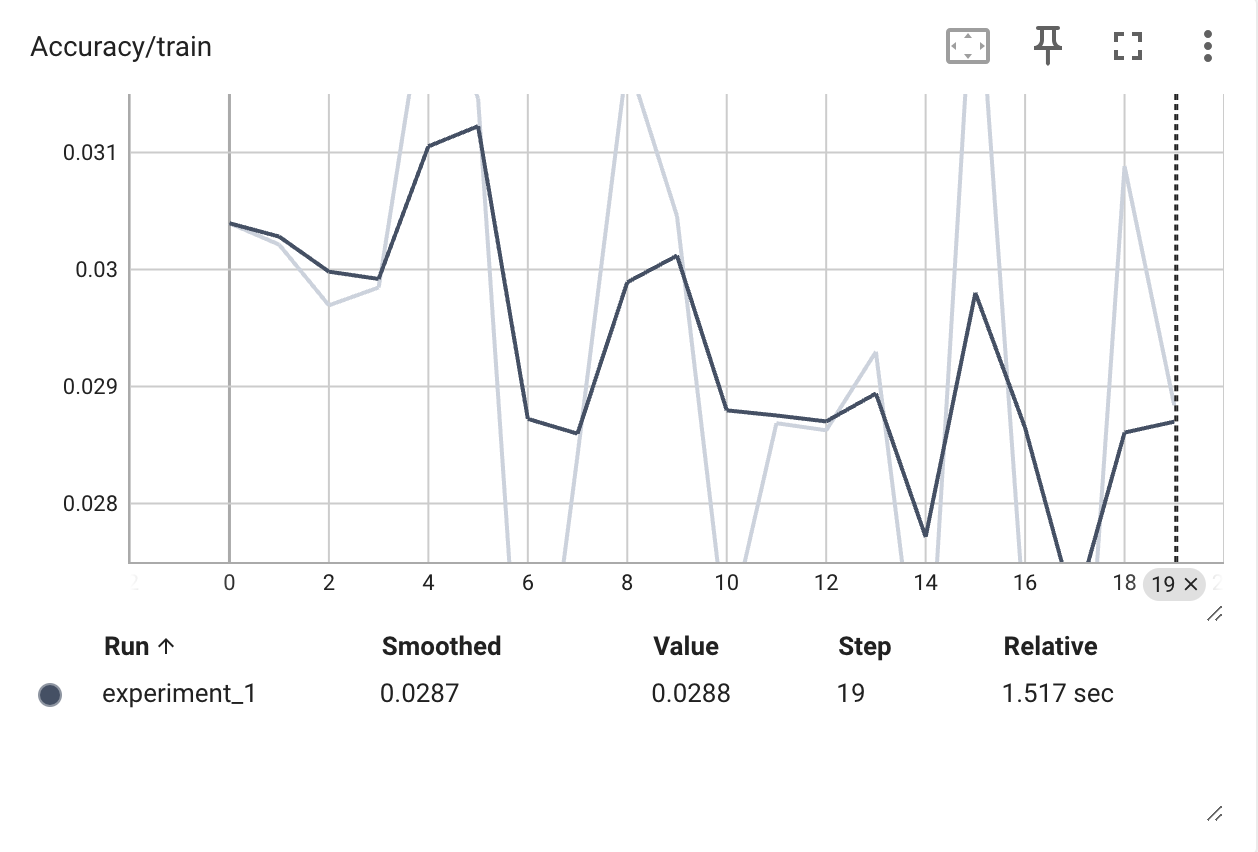

The training accuracy is 0.0288, the smoothed training accuracy is 0.0287.

**Validation Accuracy:**

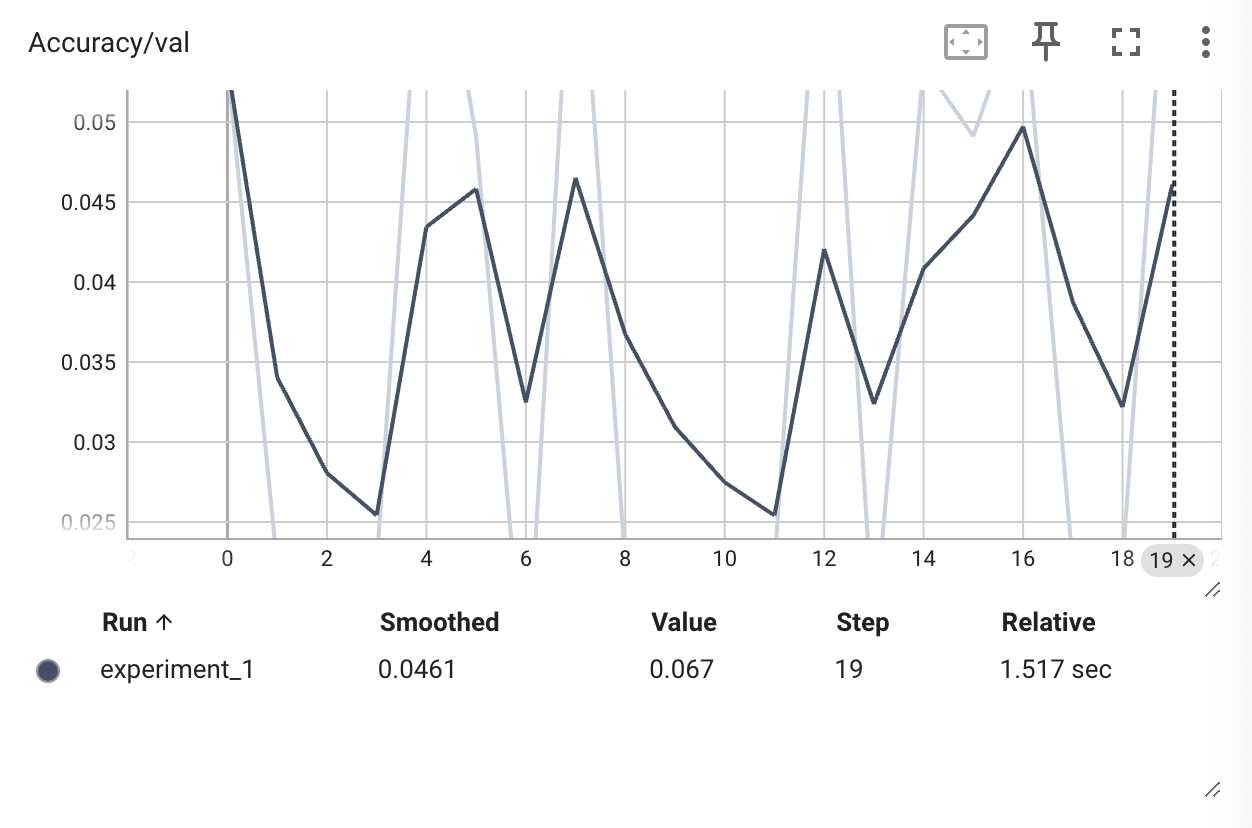

The validation accuracy is 0.067, the smoothed validation accuracy is 0.0461.

Based on the accuracy values, the model appears to be underfitting the data, possibly because there are not enough layers or neurons, noisy input, or an incorrect learning rate. In both the training and validation accuracies there is a lot of variance on the graphs.

**Training Loss:**

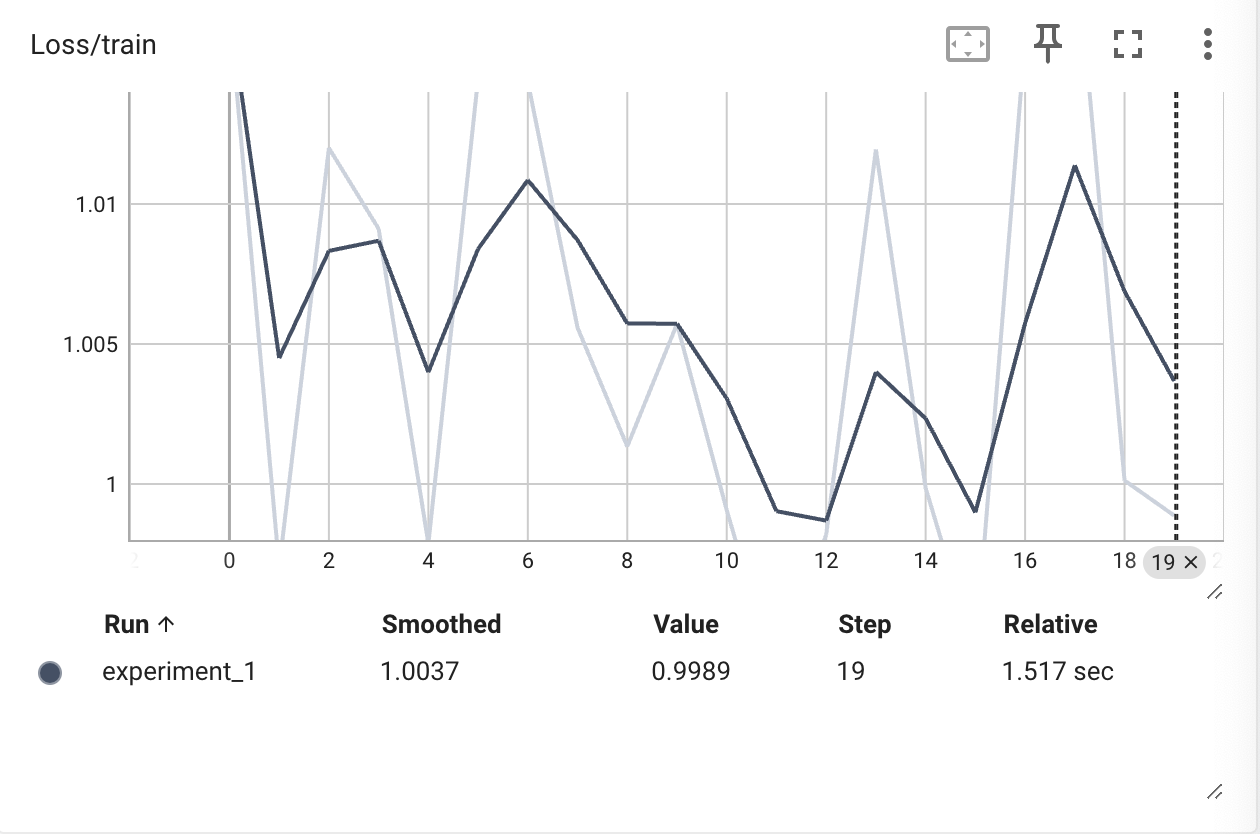

The training loss is 0.9989, the smoothed training loss is 1.0037.

**Validation Loss:**

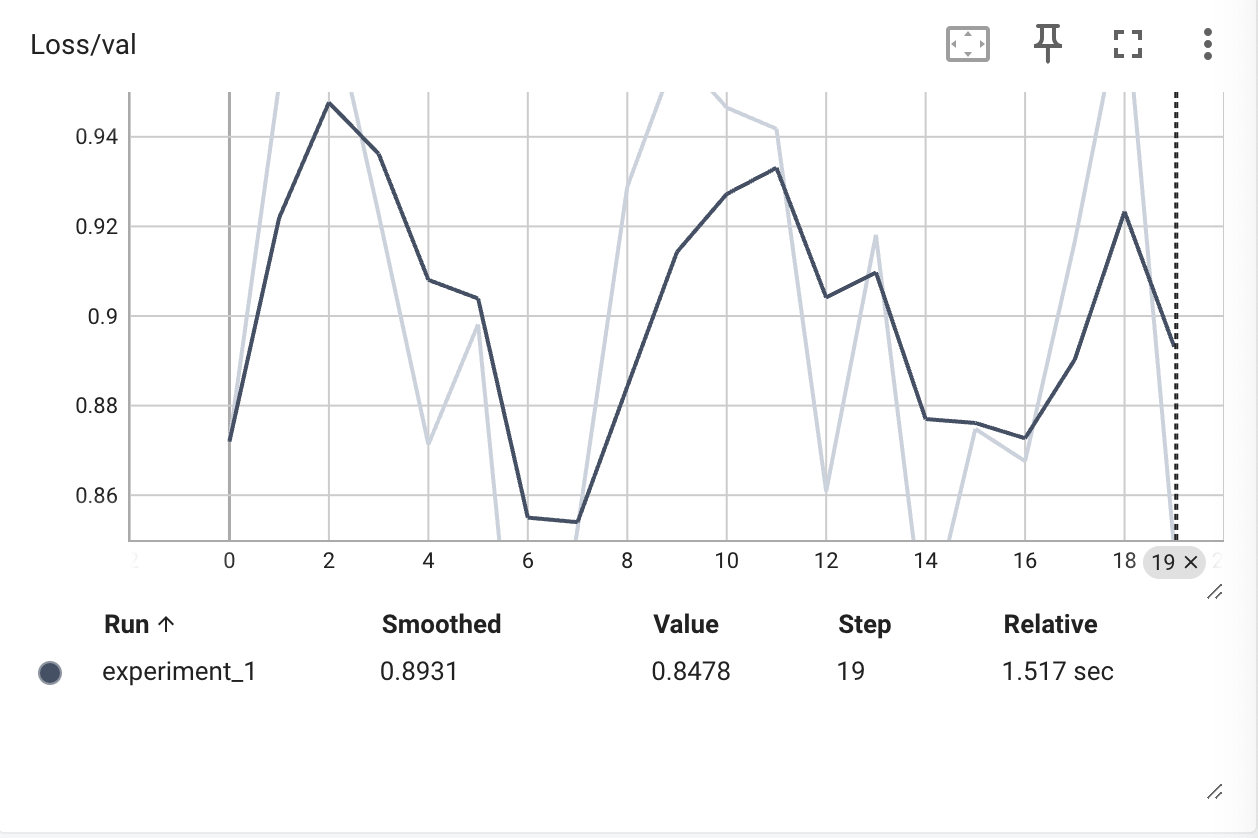

The validation loss is 0.8478, the smoothed validation loss is 0.8931.

The training and validation loss values also depict that the model is underfitting, as they are very high. This suggests that the model may be too simple, or that there was not enough training. The training and validation loss graphs also have a lot of variance, similar to the accuracy graphs.

All of the graphs took the same amount of time to train, 1.517 seconds, which is fast. This makes the issue of a lack of training (or training too fast) likely. Increasing the model size, adding hidden layers or adding more neurons per layer, may aid this issue, as well as using a different activation function.


**Part 6:**
**Analysis and Documentation**

The models included in this segment are basic, optimal, overfitting, and underfitting, as well as the values from experiment 1.


**Training Accuracy for all Models**

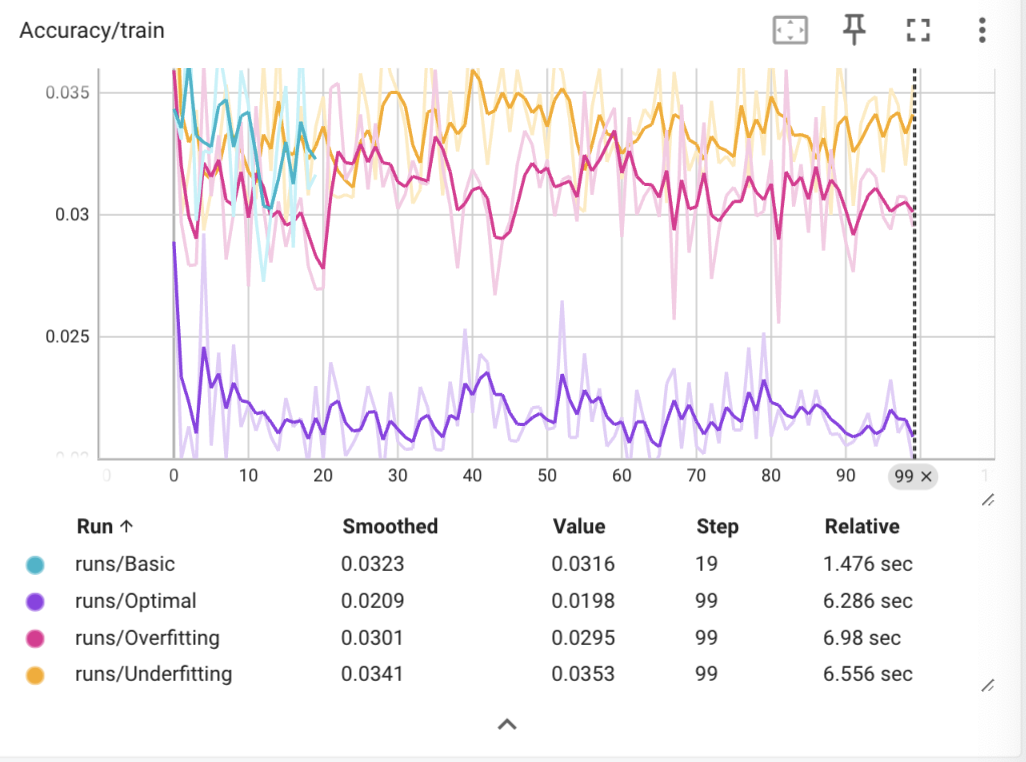

Based on this tensorboard, the training accuracies for all of the models were relatively low, similar to those of experiment 1. The Basic model took the least amount of time and the least number of steps to converge, with the other 3 models all requiring much more time. The smoothed accuracy values varied slightly from the actual accuracy values. 


**Validation Accuracy for all Models**

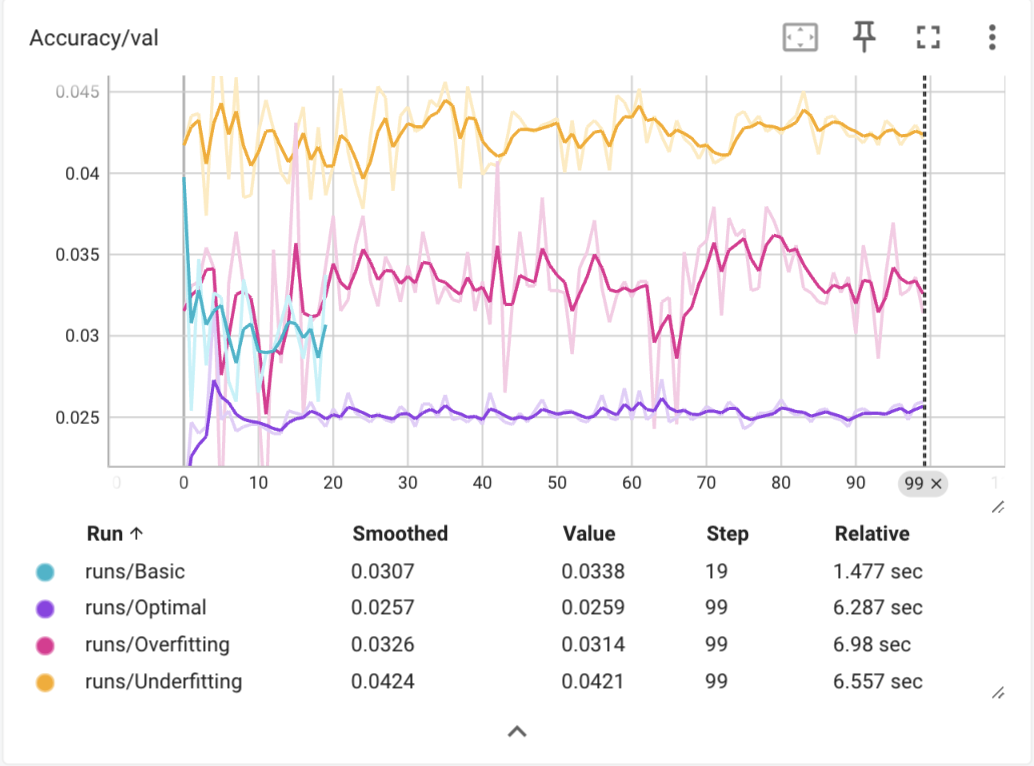

The validation accuracies are all slightly higher than the training accuracies. Although the accuracies are still low, this suggests that regularization had a positive impact on the model. The validation accuracies had less variance than the training accuracies in the previous graph. Similarly, the basic model required the least amount of time and the least number of steps to converge than the other three models.


**Training Loss for all Models**

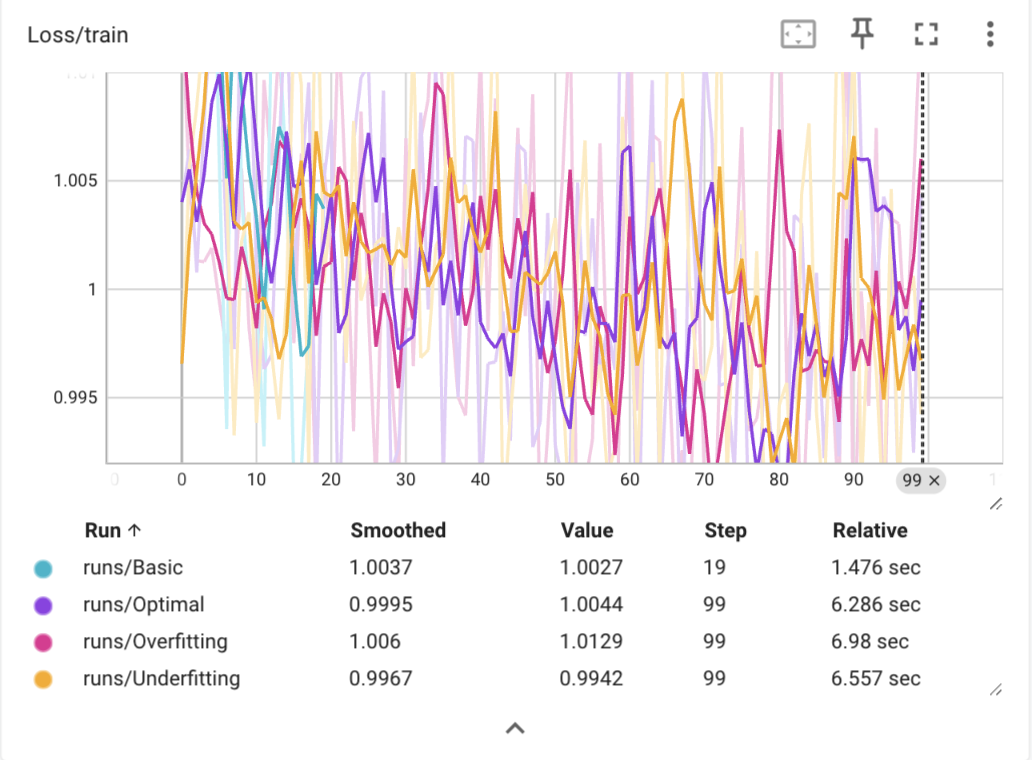

The training losses were all high, a high loss value suggests the model is not learning well, and is underfitting. Like in the previous models, the basic model required the least amount of time and the least number of steps to converge. Overall, there appears to be a lot of variance in the training losses.


**Validation Loss for all Models**

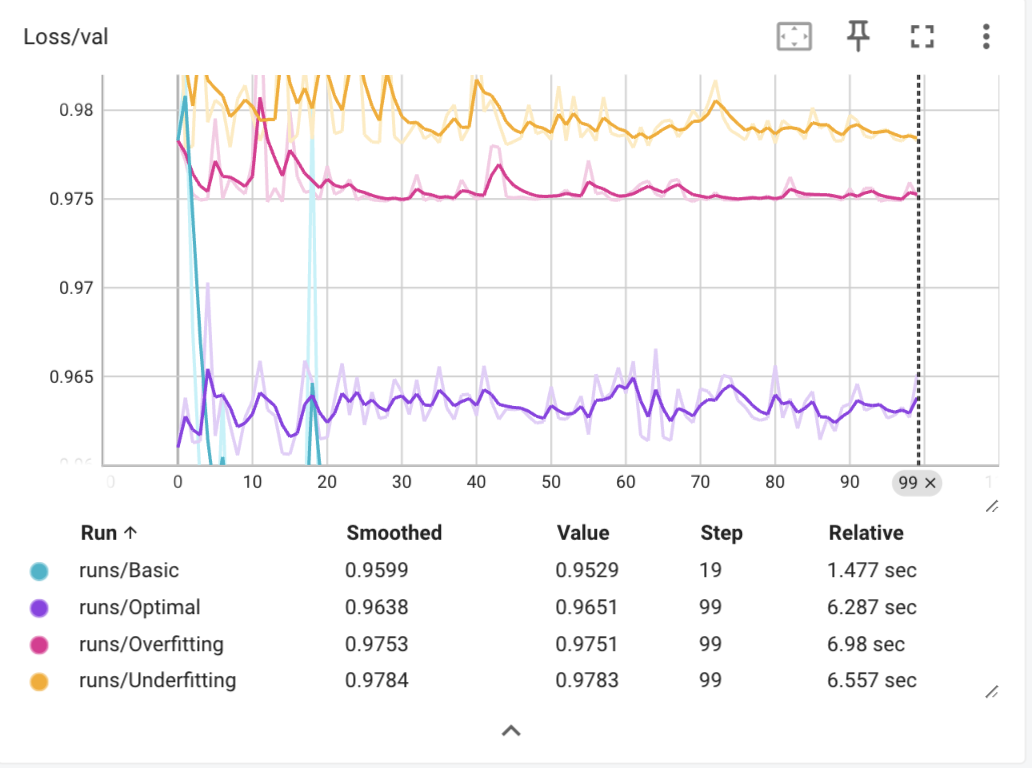

The validation loss values were all smaller than the training loss values. This suggests the model is generalizing well. Similarly to the previous models, the basic model requires the least amount of time and the least number of steps to converge. The smoothed loss values and the actual loss values are more similar than in previous graphs. Visually, the basic model had a lot of variance, however, the optimal, overfitting, and underfitting models had less variance than in the training loss graph.


**Summary**

Overall, all of the models (basic, optimal, overfitting, underfitting, and experiment 1) all experienced underfitting. This could be a coding error, but I would suggest implementing more regularization techniques, such as dropout or weight decay, and training in smaller batches. 

To improve the accuracies, adding layers or neurons would allow the model to learn more patterns, as well as using different activation functions to assist with faster learning. A lower learning rate could also be helpful, as well as letting the model run for more epochs.

To improve the loss values, adding hidden layers, more neurons per layer, or using different activation functions could help the model's learning and avoid vanishing gradients. Adjusting the learning rate to be higher could also help with the similarities of the losses for each model, as well as allowing the model to train for more epochs.